# Read in Clean Data

This notebook reads in the data cleaned during part one of EDA and creates several models in an attempt to identify a model that balances accurate predictions with overall interpretability.


In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

sklearn.set_config(display='diagram')

In [47]:
pd.set_option('display.max_rows',None)

In [48]:
# https://stackoverflow.com/questions/33952142/prevent-pandas-from-interpreting-na-as-nan-in-a-string
train = pd.read_csv('./datasets/ames_train_clean.csv', keep_default_na=False)
test = pd.read_csv('./datasets/ames_test_clean.csv', keep_default_na=False)

In [49]:
train.drop(columns='Unnamed: 0', inplace=True)
test.drop(columns='Unnamed: 0', inplace=True)

In [50]:
# add col overall qual * exter qual
train['OverallQual_x_ExterQual'] = train['Overall Qual'] * train['Exter Qual']
test['OverallQual_x_ExterQual'] = test['Overall Qual'] * test['Exter Qual']

In [51]:
#train.drop(columns=['Id', 'PID', 'MS Zoning', 'Alley', 'Land Contour', 'Lot Config', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
#                   'Year Built', 'Year Remod/Add', ''])
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,House_Age,OverallQual_x_ExterQual
0,109,533352170,60,RL,0.0,13517,1,NA,3,Lvl,...,0,0,NA,0,3,2010,WD,130500,34,18
1,544,531379050,60,RL,43.0,11492,1,NA,3,Lvl,...,0,0,NA,0,4,2009,WD,220000,13,21
2,153,535304180,20,RL,68.0,7922,1,NA,4,Lvl,...,0,0,NA,0,1,2010,WD,109000,57,10
3,318,916386060,60,RL,73.0,9802,1,NA,4,Lvl,...,0,0,NA,0,4,2010,WD,174000,4,10
4,255,906425045,50,RL,82.0,14235,1,NA,3,Lvl,...,0,0,NA,0,3,2010,WD,138500,110,12


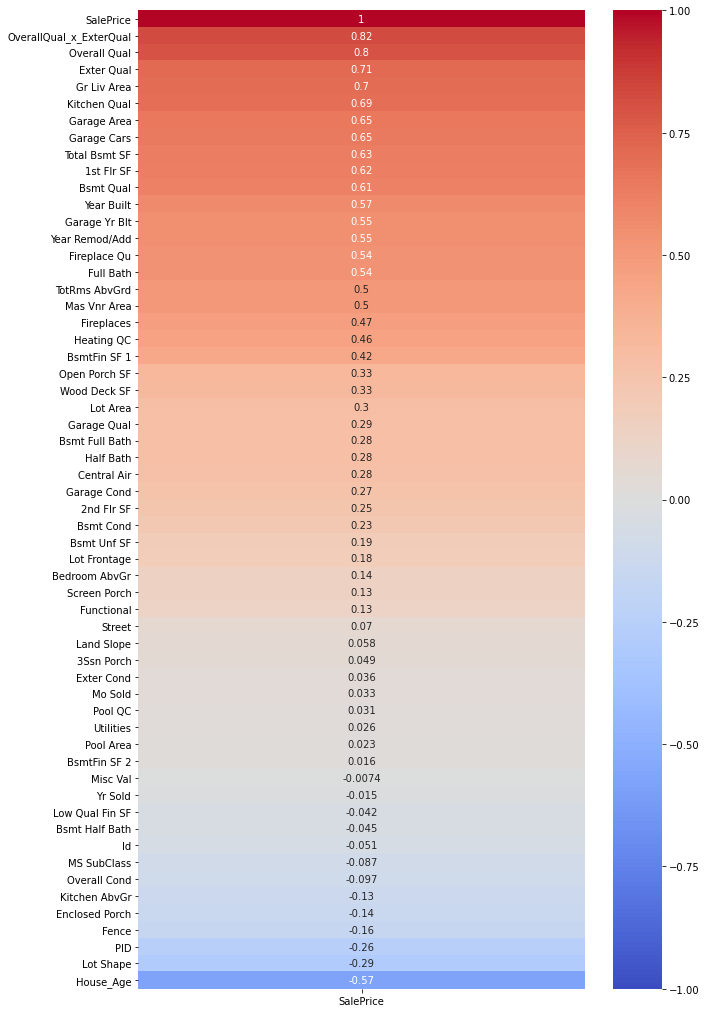

In [52]:
plt.figure(figsize=(10, 18))
sns.heatmap(train.corr()[['SalePrice']].sort_values(by=['SalePrice'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

# Model #1
## Simple Linear Regression (One Variable)

Based on our correlation matrix, Overall Qual was highly positively correlated with SalePrice. I want to see if building a simple model with just that variable can generate decent predictions.

In [9]:
X = train[['Overall Qual']]
y = train['SalePrice']
#X_test = test[['Overall Qual']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
lr =  LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [13]:
print(f'Train R2: {lr.score(X_train, y_train)}')
print(f'Test R2: {lr.score(X_test, y_test)}')

Train R2: 0.6333219308225757
Test R2: 0.6617682426512024


In [20]:
print(f'Train RMSE: {mean_squared_error(y_train, lr.predict(X_train), squared=False)}')
print(f'Train RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared=False)}')

Train RMSE: 48156.64923160143
Train RMSE: 45571.38745636498


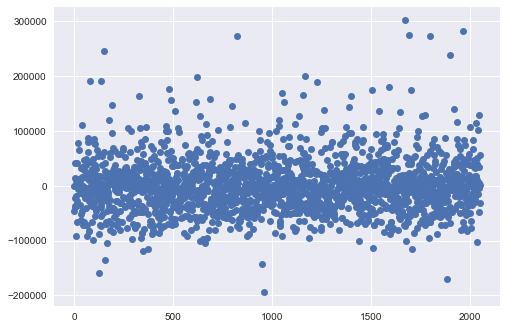

In [33]:
resids = y_train - preds

plt.plot(resids, 'o');

In [91]:
lr.coef_, lr.intercept_

(array([44318.64154347]), -89719.71949544657)

**Model 1 Summary:** 

A simple, single variable linear regression doesn't do so bad at guessing sale price. 

66.1% of the variance in SalePrice can be explained by variations in Overall Qual (compared to a model with no predictors).

This model actually performed a little better on the unseen test data than on the training set.

---

# Model #2
## Logistic Regression with Overall Qual * Exter Qual, Gr Liv Area and Neighborhood

The linear regression performed somewhat better than simply taking the mean of SalePrice. This model looks at our new engineered variable Overall Qual * Exter Qual, Gr Liv Area and Neighborhood. 


Since Neighborhood is a categorical variable, we will use a column transformer

In [61]:
# set Model 2 X and Y
X = train[['OverallQual_x_ExterQual', 'Gr Liv Area', 'Neighborhood']]
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [62]:
ohe = OneHotEncoder(sparse=False, drop='if_binary', handle_unknown='ignore')

ct = make_column_transformer(
    (ohe, ['Neighborhood']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

#params = {'logisticregression__max_iter': }

pipe = make_pipeline(ct, StandardScaler(),LogisticRegression(max_iter=10_000) )
# pipe.fit(X, y)
# pipe.score(X, y)

In [63]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Neighborhood'])],
                                   verbose_feature_names_out=False)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [64]:
print(f'Train R2: {pipe.score(X_train, y_train)}')
print(f'Test R2: {pipe.score(X_test, y_test)}')

Train R2: 0.09752925877763328
Test R2: 0.005847953216374269


In [66]:
print(f'Train RMSE: {mean_squared_error(y_train, pipe.predict(X_train), squared=False)}')
print(f'Train RMSE: {mean_squared_error(y_test, pipe.predict(X_test), squared=False)}')

Train RMSE: 40635.0012096012
Train RMSE: 44139.14742168295


### Model 2 Summary

Terrible R2 Score, but RMSE is comparable to the first model. Regardless, given the terrible accuracy of this Logistic Regression model, perhaps we should adjust it and create a model 2.5

# Model #2.5

Here we swapped out LogisticRegression for a Ridge Model. GridSearchCV was used to search over and find the best alpha parameters

In [67]:
alt_params = {'ridge__alpha': [1, 5, 10, 20, 50, 100]}
pipe2 = make_pipeline(ct, StandardScaler(),Ridge())

In [68]:
gs = GridSearchCV(estimator=pipe2, param_grid=alt_params)

In [69]:
gs.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Foun

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Neighborhood'])],
                                                          verbose_feature_names_out=False)),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [1, 5, 10, 20, 50, 100]})

In [70]:
gs.best_params_

{'ridge__alpha': 50}

In [ ]:
preds = gs.predict(X)
rmse = mean_squared_error(y, preds, squared=False)
rmse

In [71]:
print(f'Train R2: {gs.score(X_train, y_train)}')
print(f'Test R2: {gs.score(X_test, y_test)}')

Train R2: 0.8150835301157088
Test R2: 0.8140574939010667


In [72]:
print(f'Train RMSE: {mean_squared_error(y_train, gs.predict(X_train), squared=False)}')
print(f'Train RMSE: {mean_squared_error(y_test, gs.predict(X_test), squared=False)}')

Train RMSE: 34198.069449034934
Train RMSE: 33788.92697117561


### Model 2/2.5 Summary

Swapping LogisticRegression for a Ridge clearly improved the Model 2's accuracy. Here we can see the model perform comporably on the training and test sets. About 81.4% of the variance in sale price can be explained using only 'OverallQual_x_ExterQual', 'Gr Liv Area' and 'Neighborhood'.

A more complex model will likely boost R2 score and lower RMSE

---

# Model #3 
## Pipeline with StandardScaler, SelectKBest, Lasso, GridSearchCV 

Use almost all the variables this time, dropping only a small handful that had tiny correlations in our heatmap

In [75]:
X = train.drop(columns=['PID', 'Id', 'Yr Sold', 'Misc Val', 'BsmtFin SF 2' ,'SalePrice', 'Misc Feature'])
# X = test.drop(columns=['PID', 'Id', 'Yr Sold', 'Misc Val', 'BsmtFin SF 2' , 'Misc Feature']) #test set for Kaggle sub
y  = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [76]:
ohe = OneHotEncoder(sparse=False, drop='if_binary', handle_unknown='ignore')

ct = make_column_transformer(
    (ohe, make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [81]:
# make pipeline with column transformer (smart_encoder), Standard Scaler & Lasso
pipe = make_pipeline(ct, StandardScaler(), SelectKBest(k=150), Lasso())

# 'selectkbest__k':
params = {'standardscaler__with_mean': [True, False], 'standardscaler__with_std': [True, False], 'lasso__alpha': [0.01, 0.5, 1, 5, 10] }

gs = GridSearchCV(estimator=pipe, param_grid=params)

gs.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  0  28  60  92 124 125 149 171 183] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.700e+11, tolerance: 7.781e+08
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklea

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9beedcce80>)],
                                                          verbose_feature_names_out=False)),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest', SelectKBest(k=150)),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.01, 0.5, 1, 5, 10],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False]})

In [82]:
print(f'Train R2: {gs.score(X_train, y_train)}')
print(f'Test R2: {gs.score(X_test, y_test)}')

Train R2: 0.9137282881311061
Test R2: 0.9030467807060512


/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [83]:
print(f'Train RMSE: {mean_squared_error(y_train, gs.predict(X_train), squared=False)}')
print(f'Train RMSE: {mean_squared_error(y_test, gs.predict(X_test), squared=False)}')

Train RMSE: 23358.664060911506
Train RMSE: 24398.671360303695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [84]:
gs.best_params_

{'lasso__alpha': 10,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': False}

In [85]:
gs.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9beef33be0>)],
                                   verbose_feature_names_out=False)),
                ('standardscaler', StandardScaler(with_std=False)),
                ('selectkbest', SelectKBest(k=150)),
                ('lasso', Lasso(alpha=10))])

In [86]:
coefs = gs.best_estimator_.named_steps['lasso'].coef_
coefs.shape

(150,)

In [87]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
# https://stackoverflow.com/questions/39839112/the-easiest-way-for-getting-feature-names-after-running-selectkbest-in-scikit-le
cols_mask = gs.best_estimator_.named_steps['selectkbest'].get_support()
X_cols = gs.best_estimator_.named_steps['columntransformer'].get_feature_names_out()
cols = X_cols[cols_mask == True]

In [88]:
lasso_coefs = pd.DataFrame({'Features': cols, 'Coefs': coefs})
lasso_coefs.sort_values('Coefs', ascending=False)

,Features,Coefs
49,Roof Matl_WdShngl,448732.579266
48,Roof Matl_WdShake,394586.050557
45,Roof Matl_CompShg,391831.791698
46,Roof Matl_Membran,388049.777234
47,Roof Matl_Tar&Grv,376967.888327
16,Neighborhood_GrnHill,116627.005661
22,Neighborhood_StoneBr,53984.404098
101,Sale Type_Con,39488.115507
20,Neighborhood_NridgHt,36991.506563
19,Neighborhood_NoRidge,34931.531274


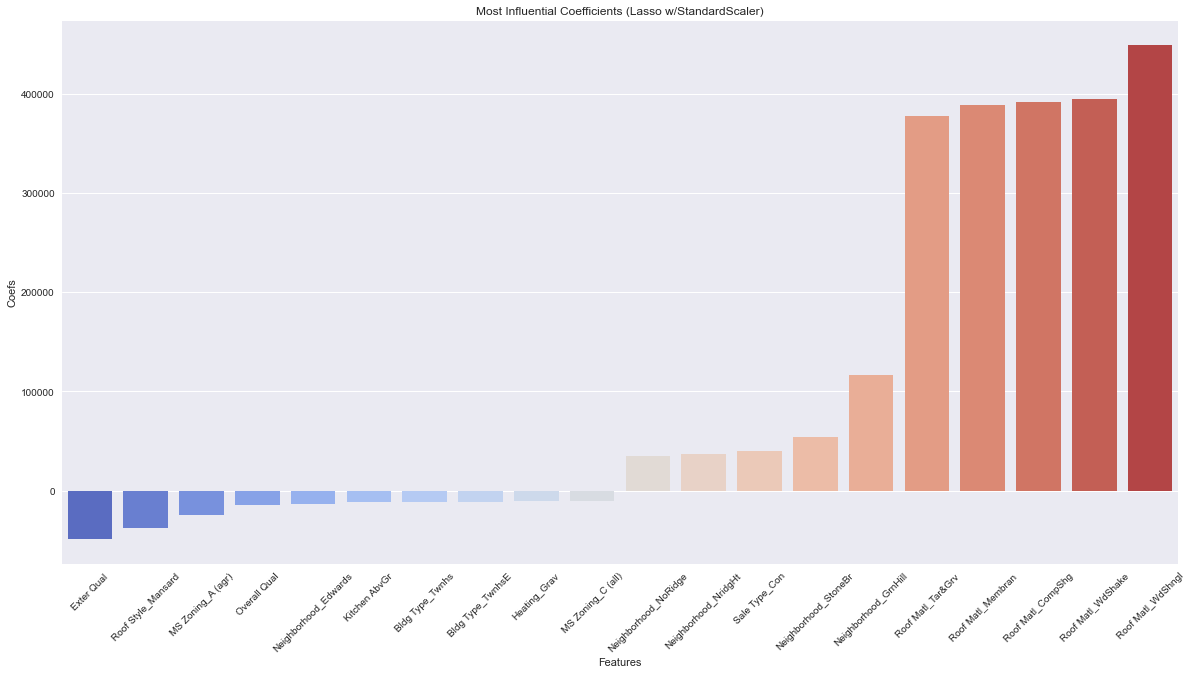

In [90]:
#plot coefs
lasso_largest = lasso_coefs.nlargest(10, 'Coefs')
lasso_smallest = lasso_coefs.nsmallest(10, 'Coefs')

lasso_largest_smallest = pd.concat([lasso_smallest, lasso_largest])

plt.style.use('seaborn')
plt.subplots(figsize=(20, 10))
sns.barplot(data = lasso_largest_smallest.sort_values('Coefs'), x='Features', y='Coefs', palette='coolwarm')
plt.title('Most Influential Coefficients (Lasso w/StandardScaler)')
plt.xticks(rotation=45);

### Model #3 Summary

By utilizing a column transformer, a StandardScaler(), SelectKBest() and a Lasso(), we've managed to create a model through which 90.3% of the variance in SalePrice can be explained by the 150 variables that were chosen as the 'best'/most influential coefficients in building our model. It produced the lowest RMSE of all our models.

I extracted the feature names and coefs and plotted just a small handful of them above (the highest/lowest 10). We can see here that this model identified several types of roofing material as being highly positively predictive of price, as well as several of the neighborhoods previously identified as having SalePrice distributions outside the mean/median. 

Additionally, we see that this model shows the Edwards neighborhood, Overall Qual AND Exter Qual as negatively correlated. Our engineered variable does not appear in either the highest or lowest 10 coefficients. 

This model could be improved by removing the outliers across a few key variables (namely Gr Liv Area and Lot Size). Overall, it is good for the Kaggle competition, but not for an end user who wants to derive insights about specific house features that should result in a higher or lower sale price. 

---


# Conclusion

Overall, we are able to get pretty good SalePrice predictions. Neighborhood is important, as is size and any features related to perceived the Quality/Appearance of the House. There is clearly some multicolinearity present in the data, which warrant further investigation if building an *accurate* and *interpretable* model is the ultimate goal. 